In [1]:
%matplotlib inline
import os 
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import datetime as dt
import seaborn as sns
import glob
import time

sns.set_context("notebook")

import home
import dicts

# Calculate the flowering dates from the aGDD & the floweringGDD

In [ ]:
def sort_files(path):
    available_files = glob.glob(path)
    if len(available_files) > 1:
        file = sorted(available_files,key=os.path.getmtime)[-1]
    elif len(available_files) == 1:
        [file] = available_files
    return file

crop = "maize"
scenario = 2093
watering = "rf"
res = "025"

for scenario in [2093]:
    planting = "ggcmi"
    print(scenario,planting,crop)
    ggcmi_crop = dicts.crop_dict[crop]['GGCMI_crop_short']
    name = "aGDD"
    GDD_file = sort_files(f"{home.hspath}/HI_final/*ggcmi*/scenic_EU{res}_f{scenario}_GDD_{crop}_{watering}*.nc")
    GDD_dyn = sort_files(f"{home.hspath}/HI_final/*dynamic*/scenic_EU{res}_f{scenario}_GDD_{crop}_{watering}*.nc")
    flowering_file = sort_files(f"{home.hspath}/HI_final/scenic_EU{res}_f2017_flowering_{crop}_{watering}*.nc")
    data_ggcmi = xr.load_dataset(GDD_file)
    data_dyn = xr.load_dataset(GDD_dyn)
    data_m = (xr.merge([data_ggcmi.rename({"aGDD":"aGDD_ggcmi"})[["date","tmax","tavg","aGDD_ggcmi"]],
                        data_dyn.rename({"aGDD":"aGDD_dyn"})[["date","tmax","tavg","aGDD_dyn"]]]))
    flowering = xr.load_dataset(flowering_file)
    if (scenario != 2017):
        flowering = flowering.sel(date = flowering.date.values[1:])
    td = data_m.date[0].dt.year.values - flowering.date[0].values
    flowering["date"] = flowering.date + td
    flowering["flowering_doy"] = flowering.flowering_date.dt.dayofyear
    # merge flowering and gdd data 
    ds_f= xr.merge([data_m,flowering.mean(dim="date")])
    ds_f["doy"] = ds_f.date.dt.dayofyear
    ds_f = ds_f[["date","tmax","tavg","flowering","flowering_doy","aGDD_ggcmi","aGDD_dyn","doy"]]
    ds_f["GDD_diff"] = ds_f["aGDD_dyn"] - ds_f["aGDD_ggcmi"]
    ds_f["year"] = ds_f.date.dt.year

    #get the first date where gdd reaches the flowering(gdd) goal 
    # for ggcmi do ds_f.aGDD_ggcmi, for dynamic do ds_f.aGDD_dyn
    flowering_ds = (ds_f.where(ds_f[f"aGDD_{planting}"] >= ds_f.flowering,drop=True).
          to_dataframe().
          reset_index("date").
          groupby(["year","lat","lon"]).
          min().
          to_xarray())
    flowering_doy = flowering_ds.doy
    flowering_date = flowering_ds.date
    if "dyn" in planting:
        planting = "dynamic"
    flowering_ds_2 = xr.merge([flowering_doy,flowering_date])
    flowering_ds_2.attrs = {"crop":crop,"scenario":"scenario","grid_resoltuion":res,"planting":planting}

   
    #(flowering_ds_2.
     #to_netcdf(f"{home.hspath}/HI_final/{planting}_planting/scenic_EU025_f{scenario}_flowering_{crop}_rf.nc"))

2093 ggcmi maize


In [4]:
flowering_ds

<xarray.Dataset>
Dimensions:        (year: 6, lat: 130, lon: 168)
Coordinates:
  * year           (year) float64 2.017e+03 2.018e+03 ... 2.021e+03 2.022e+03
  * lat            (lat) float64 34.88 35.12 35.38 35.88 ... 66.88 67.12 67.38
  * lon            (lon) float64 -10.38 -10.12 -9.875 ... 30.88 31.12 31.38
Data variables:
    date           (year, lat, lon) datetime64[ns] NaT NaT NaT ... NaT NaT NaT
    tmax           (year, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    tavg           (year, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    flowering      (year, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    flowering_doy  (year, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    aGDD_ggcmi     (year, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    doy            (year, lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [24]:

def sort_files(path):
    available_files = glob.glob(path)
    if len(available_files) > 1:
        file = sorted(available_files,key=os.path.getmtime)[-1]
    elif len(available_files) == 1:
        [file] = available_files
    return file

crop = "winter_wheat"
#scenario = 2093
watering = "rf"
res = "025"

for scenario in [2017]:
    planting = "ggcmi"
    print(scenario,planting,crop)
    ggcmi_crop = dicts.crop_dict[crop]['GGCMI_crop_short']
    name = "aGDD"
    GDD_file = sort_files(f"{home.hspath}/HI_final/*ggcmi*/scenic_EU{res}_f{scenario}_GDD_{crop}_{watering}*.nc")
    #GDD_dyn = sort_files(f"{home.hspath}/HI_final/*dynamic*/scenic_EU{res}_f{scenario}_GDD_{crop}_{watering}*.nc")
    flowering_file = sort_files(f"{home.hspath}/HI_final/scenic_EU{res}_f2017_flowering_{crop}_{watering}*.nc")
    data_ggcmi = xr.load_dataset(GDD_file).rename({"aGDD":"aGDD_ggcmi"})[["date","tmax","tavg","aGDD_ggcmi"]]
    
    flowering = xr.load_dataset(flowering_file)
    if (scenario != 2017):
        flowering = flowering.sel(date = flowering.date.values[1:])
    td = data_ggcmi.date[0].dt.year.values - flowering.date[0].values
    flowering["date"] = flowering.date + td
    flowering["flowering_doy"] = flowering.flowering_date.dt.dayofyear
    # merge flowering and gdd data 
    ds_f= xr.merge([data_ggcmi,flowering.mean(dim="date")])
    ds_f["doy"] = ds_f.date.dt.dayofyear
    ds_f = ds_f[["date","tmax","tavg","flowering","flowering_doy","aGDD_ggcmi","doy"]]
    #ds_f["GDD_diff"] = ds_f["aGDD_dyn"] - ds_f["aGDD_ggcmi"]
    ds_f["year"] = ds_f.date.dt.year

    #get the first date where gdd reaches the flowering(gdd) goal 
    # for ggcmi do ds_f.aGDD_ggcmi, for dynamic do ds_f.aGDD_dyn
    flowering_ds = (ds_f.where(ds_f[f"aGDD_{planting}"] >= ds_f.flowering,drop=True).
          to_dataframe().
          reset_index("date").
          groupby(["year","lat","lon"]).
          min().
          to_xarray())
    flowering_doy = flowering_ds.doy
    flowering_date = flowering_ds.date
    if "dyn" in planting:
        planting = "dynamic"
    flowering_ds_2 = xr.merge([flowering_doy,flowering_date])
    flowering_ds_2.attrs = {"crop":crop,"scenario":"scenario","grid_resoltuion":res,"planting":planting}

   
    (flowering_ds_2.
     to_netcdf(f"{home.hspath}/HI_final/{planting}_planting/scenic_EU025_f{scenario}_flowering_{crop}_rf.nc"))

2017 ggcmi winter_wheat


# Flowering distributions

## in the different crops in pd

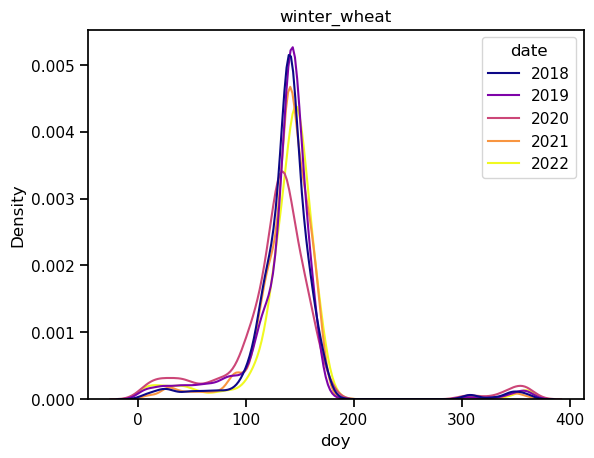

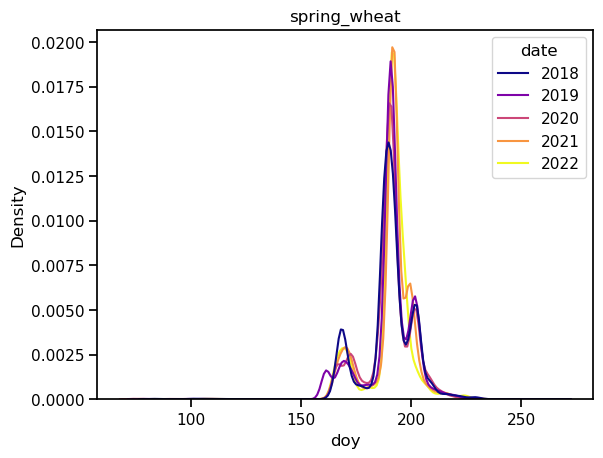

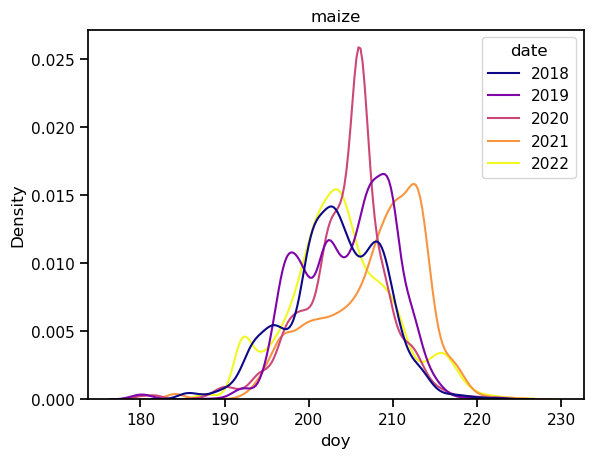

In [23]:
for crop in ["winter_wheat","spring_wheat","maize"]:
    flowering = xr.open_dataset(f"{home.hspath}/HI_final/scenic_EU025_f2017_flowering_{crop}_rf.nc")
    flowering["doy"] = flowering.where(flowering.flowering >0,drop=True).flowering_date.dt.dayofyear
    fig, ax = plt.subplots()
    sns.kdeplot(flowering.to_dataframe().dropna(),x="doy",ax=ax,hue="date",palette="plasma")
    #ax.set_xlim(0,365)
    ax.set_title(crop)
    plt.show()

## flowering distribution - dynamic planting

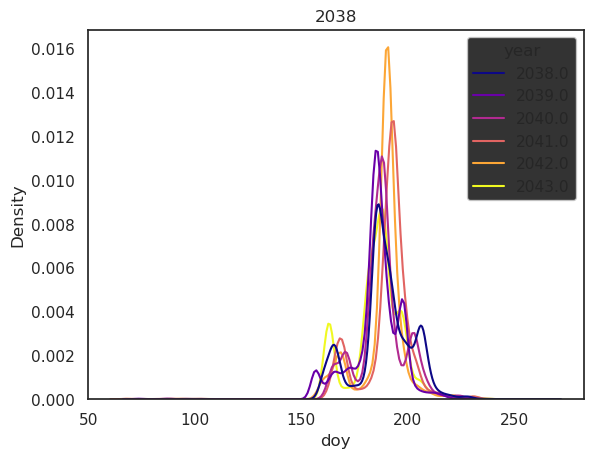

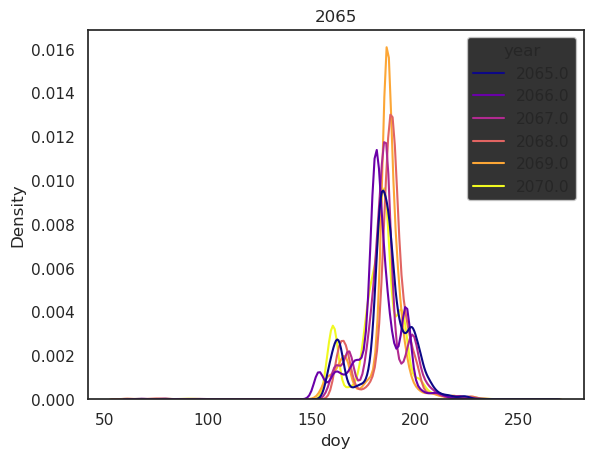

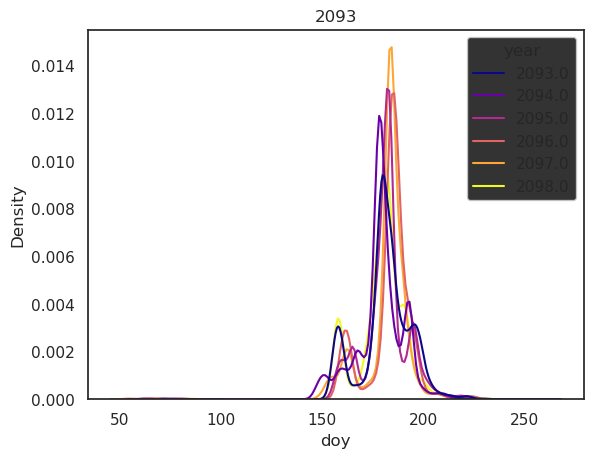

In [43]:
for scenario in [2038,2065,2093]:  
    flowering = xr.open_dataset(f"{home.hspath}/HI_final/ggcmi_planting/scenic_EU025_f{scenario}_flowering_spring_wheat_rf.nc")
    fig, ax = plt.subplots()
    sns.kdeplot(flowering.to_dataframe().dropna(),x="doy",ax=ax,hue="year",palette="plasma")
    #ax.set_xlim(0,365)
    ax.set_title(scenario)
    plt.show()

## Ridgeplots analouge to planting dates

In [3]:
deg_list = ["ggcmi"] +["present day"]*6  + ["+2K"]*6 + ["+3K"] *6 + ["+4K"]*6
year_list =["ggcmi"] + [2017,2018,2019,2020,2021,2022]+ [2038, 2039, 2040, 2041, 2042, 2043] +[2065, 2066, 2067, 2068, 2069, 2070] +[2093, 2094, 2095, 2096, 2097, 2098]

name_dict = dict(zip(year_list,deg_list)) 
#name_dict

method_dict = {"ggcmi":"static", "dynamic": "dynamic"}

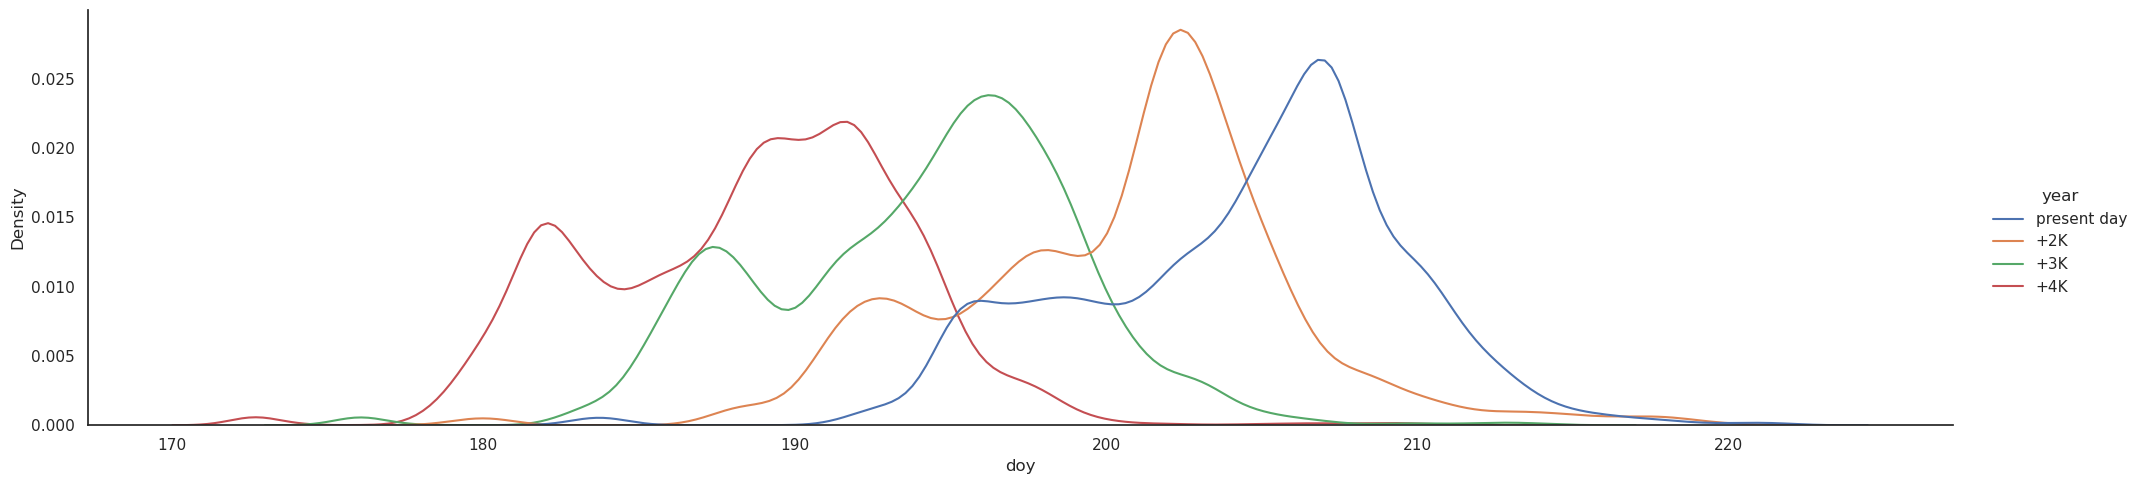

In [38]:
flowering_df = []

method = "ggcmi" #ggcmi / dynamic
crop = "maize" #winter_wheat only works with ggcmi!!

for scenario in [2017,2038,2065,2093]:
    if scenario == 2017: 
        flowering_scenario = xr.load_dataset(f"{home.hspath}/HI_final/scenic_EU025_f{scenario}_flowering_{crop}_rf.nc")
        flowering_scenario = flowering_scenario.rename({"date":"year"})
        flowering_scenario["doy"] = flowering_scenario.flowering_date.dt.dayofyear
        flowering_scenario = flowering_scenario.where(~np.isnan(flowering_scenario.flowering),drop=True)
    else: 
        flowering_scenario = xr.load_dataset(f"{home.hspath}/HI_final/{method}_planting/scenic_EU025_f{scenario}_flowering_{crop}_rf.nc")
    flowering_s_df = flowering_scenario.mean(dim=["year"]).to_dataframe().reset_index(["lat","lon"])
    flowering_s_df["year"] = name_dict[scenario]
    flowering_s_df = flowering_s_df.set_index("year")
    flowering_df.append(flowering_s_df)

    
#flowering_ggcmi_f = f"{home.hspath}/crop_calendar/GGCMI_crop_calendars_EU025/mai_rf_ggcmi_crop_calendar_EU025.nc4"
#flowering_ggcmi = xr.load_dataset(flowering_ggcmi_f)
#flowering_ggcmi = flowering_ggcmi.where(flowering_scenario.isel(year=0).flowering_day >0).assign_coords({"year": "present day"})
#flowering_ggcmi_df = flowering_ggcmi.flowering_day.to_dataframe().reset_index(["lat","lon"]).set_index("year")
flowering_m_df = pd.concat(flowering_df).reset_index("year")
sns.displot(flowering_m_df, x="doy",hue = "year",kind = "kde",aspect=4)

In [7]:
mean_serie

year
+2K            200.506037
+3K            194.067671
+4K            188.584098
present day    204.366754
Name: doy, dtype: float64

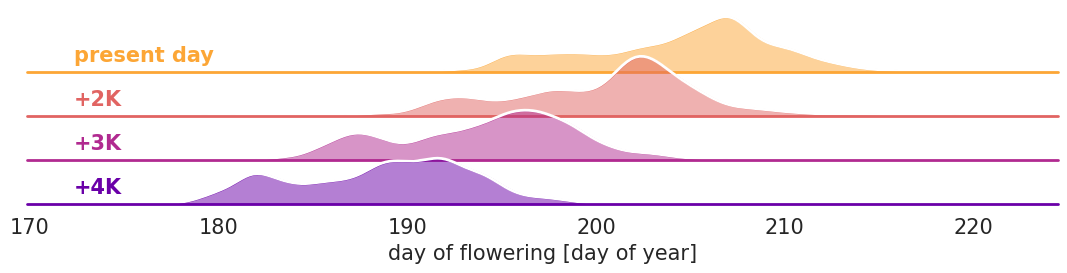

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [39]:
min_ = flowering_m_df['doy'].min()
max_ = flowering_m_df['doy'].max()

# we generate a pd.Serie with the mean flowering day for each year (used later for colors in the FacetGrid plot), and we create a new column in  dataframe
mean_serie = flowering_m_df.groupby('year')['doy'].mean()
flowering_m_df['mean_flowering'] = flowering_m_df['year'].map(mean_serie)

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# we generate a color palette with Seaborn.color_palette()
pal = sns.color_palette(palette='plasma', n_colors=len(flowering_m_df.year.unique()))

# in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
g = sns.FacetGrid(flowering_m_df, row='year', hue='mean_flowering', aspect=15, height=0.75, palette=pal)

# then we add the densities kdeplots for each month
g.map(sns.kdeplot, 'doy',
      bw_adjust=1,
      fill=True, alpha=0.5, linewidth=1.5,clip = (min_,max_))

# here we add a white line that represents the contour of each kdeplot
g.map(sns.kdeplot, 'doy', 
      bw_adjust=1,  
      color="w", lw=2,clip = (min_,max_))

# here we add a horizontal line for each plot
g.map(plt.axhline, y=0,
      lw=2, clip_on=False)

# we use matplotlib.Figure.subplots_adjust() function to get the subplots to overlap
g.fig.subplots_adjust(hspace=-0.3)

for i, ax in enumerate(g.axes.flat):
    ax.text(min_, 0.02, dict(enumerate(flowering_m_df.year.unique()))[i],
            fontweight='bold', fontsize=15,
            color=ax.lines[-1].get_color())
# eventually we remove axes titles, yticks and spines
g.set_titles("")
g.set(yticks=[],ylabel='')
g.despine(bottom=True, left=True)

plt.setp(ax.get_xticklabels(), fontsize=15, fontweight=20)
plt.xlabel('day of flowering [day of year]', fontweight= 20, fontsize=15)
if method == "dynamic": 
    g.fig.suptitle(f'Day of flowering with {method_dict[method]} planting',
                   #ha='right',
                   fontsize=20,
                   fontweight=20)

plt.show()
g.savefig(f"{home.hsplot}/flowering/ridgeplots_flowering_{method}_{crop}_meanScenarios.png",dpi=300)
g.savefig(f"{home.hsplot}/flowering/ridgeplots_flowering_{method}_{crop}_meanScenarios.pdf",dpi=300)
if crop == "maize": 
    g.savefig(f"{home.hsplot}/paper/figure5-2.eps",dpi=300)
    g.savefig(f"{home.hsplot}/paper/figure5-2_ridgeplots_flowering_{method}_{crop}_meanScenarios.png",dpi=300)

### Differences between Static and Dynamic planting in flowering for maize

In [10]:
flower_maiz_stat = flowering_m_df 

In [13]:
flower_maiz_dyn = flowering_m_df 

In [14]:
flowering_m_df["diff"] = flower_maiz_dyn.doy - flower_maiz_stat.doy

In [15]:
fl_df = flowering_m_df[["year","lat","lon","diff"]]
fl_df["dyn"] = flower_maiz_dyn["doy"]
fl_df["stat"] = flower_maiz_stat["doy"]

/tmp/ipykernel_3910846/1799932587.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fl_df["dyn"] = flower_maiz_dyn["doy"]


In [16]:
fl_df

year     lat     lon  diff  dyn  stat
0      present day  34.875 -10.375   NaN  NaN   NaN
1      present day  34.875 -10.125   NaN  NaN   NaN
2      present day  34.875  -9.875   NaN  NaN   NaN
3      present day  34.875  -9.625   NaN  NaN   NaN
4      present day  34.875  -9.375   NaN  NaN   NaN
...            ...     ...     ...   ...  ...   ...
87355          +4K  67.375  30.375   NaN  NaN   NaN
87356          +4K  67.375  30.625   NaN  NaN   NaN
87357          +4K  67.375  30.875   NaN  NaN   NaN
87358          +4K  67.375  31.125   NaN  NaN   NaN
87359          +4K  67.375  31.375   NaN  NaN   NaN

[87360 rows x 6 columns]

In [17]:
flowering_m_df.where(flowering_m_df.year != "present day")

year     lat     lon  flowering  doy  diff
0      NaN     NaN     NaN        NaN  NaN   NaN
1      NaN     NaN     NaN        NaN  NaN   NaN
2      NaN     NaN     NaN        NaN  NaN   NaN
3      NaN     NaN     NaN        NaN  NaN   NaN
4      NaN     NaN     NaN        NaN  NaN   NaN
...    ...     ...     ...        ...  ...   ...
87355  +4K  67.375  30.375        NaN  NaN   NaN
87356  +4K  67.375  30.625        NaN  NaN   NaN
87357  +4K  67.375  30.875        NaN  NaN   NaN
87358  +4K  67.375  31.125        NaN  NaN   NaN
87359  +4K  67.375  31.375        NaN  NaN   NaN

[87360 rows x 6 columns]

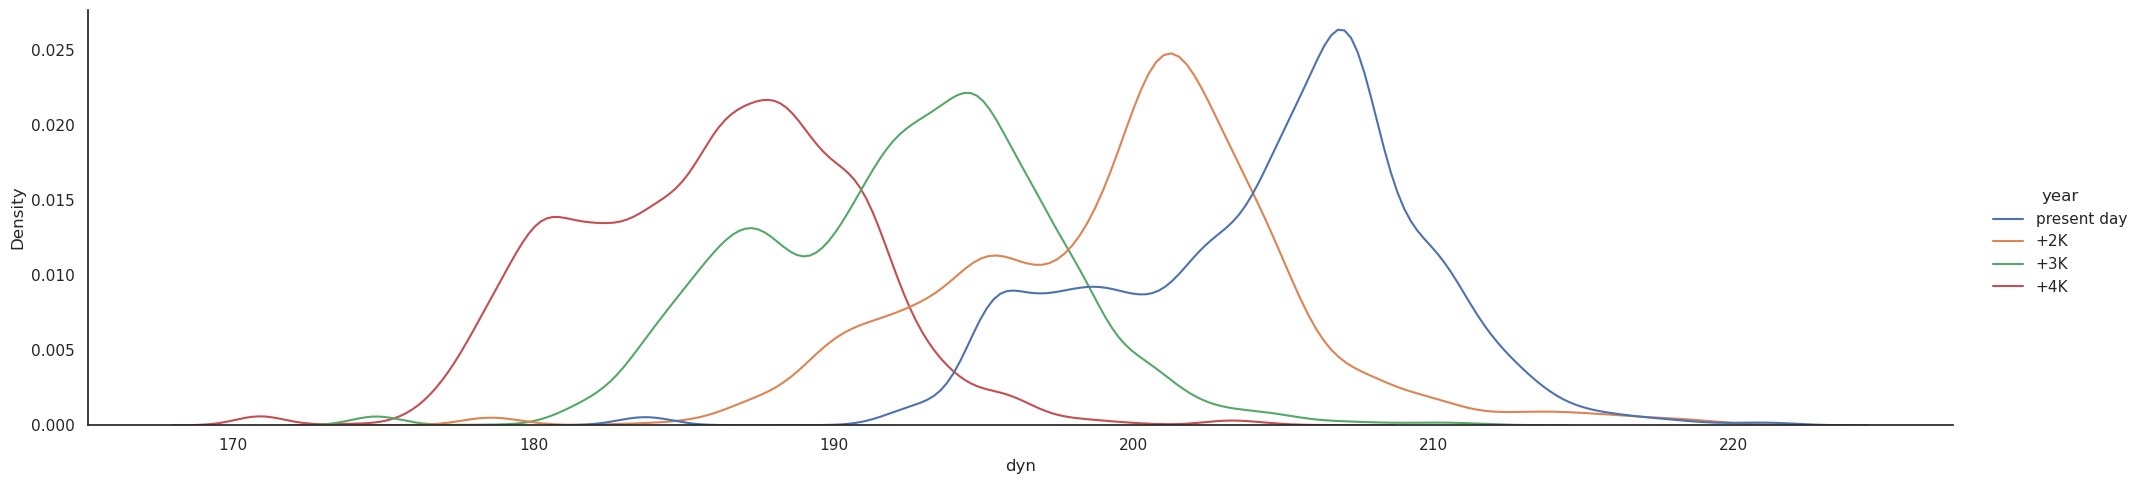

In [18]:
sns.displot(fl_df, x="dyn",hue = "year",kind = "kde",aspect=4)

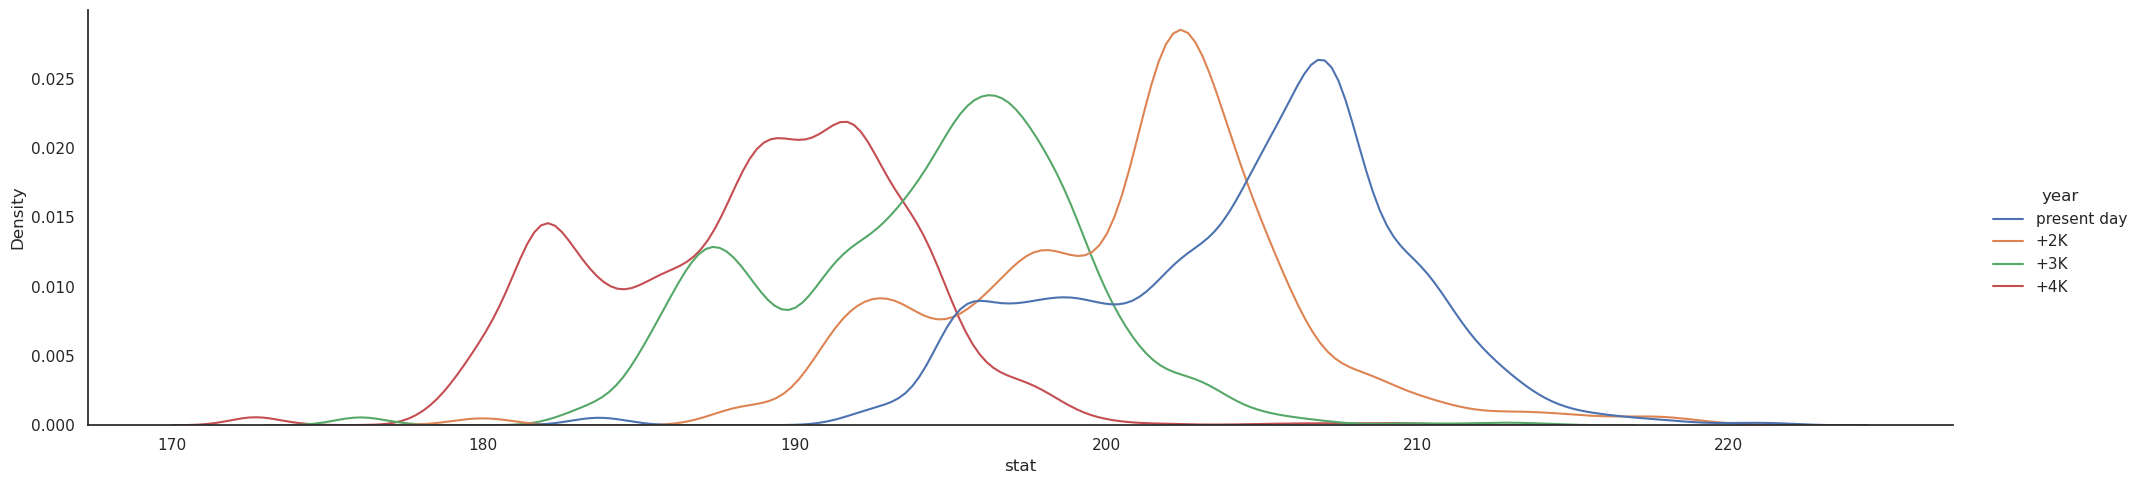

In [19]:
sns.displot(fl_df, x="stat",hue = "year",kind = "kde",aspect=4)

In [20]:
flowering_m_df['diff'].quantile(0.01)

-5.333333333333343

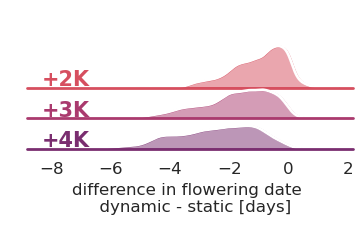

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [37]:
min_ = flowering_m_df['diff'].min() +3
max_ = flowering_m_df['diff'].max()

# we generate a pd.Serie with the mean flowering day for each year (used later for colors in the FacetGrid plot), and we create a new column in  dataframe
mean_serie = flowering_m_df.groupby('year')['diff'].mean()
flowering_m_df['mean_flowering'] = flowering_m_df['year'].map(mean_serie)

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# we generate a color palette with Seaborn.color_palette()
pal = sns.color_palette(palette='flare_r', n_colors=len(flowering_m_df.year.unique()))

# in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
g = sns.FacetGrid(flowering_m_df.where(flowering_m_df.year != "present day"), row='year', hue='mean_flowering', aspect=6, height=0.7, palette=pal)

# then we add the densities kdeplots for each month
g.map(sns.kdeplot, 'diff',
      bw_adjust=1,
      fill=True, alpha=0.5, linewidth=1.5,clip = (min_,max_))

# here we add a white line that represents the contour of each kdeplot
g.map(sns.kdeplot, 'diff', 
      bw_adjust=1,  
      color="w", lw=2,clip = (min_,max_))

# here we add a horizontal line for each plot
g.map(plt.axhline, y=0,
      lw=2, clip_on=False)

# we use matplotlib.Figure.subplots_adjust() function to get the subplots to overlap
g.fig.subplots_adjust(hspace=-0.3)

for i, ax in enumerate(g.axes.flat):
    ax.text(min_, 0.02, dict(enumerate(flowering_m_df.year.unique()[1:4]))[i],
            fontweight='bold', fontsize=15,
            color=ax.lines[-1].get_color())
# eventually we remove axes titles, yticks and spines
g.set_titles("")
g.set(yticks=[],ylabel='')
g.despine(bottom=True, left=True)

plt.setp(ax.get_xticklabels(), fontsize=12, fontweight=20)
plt.xlabel('difference in flowering date \n  dynamic - static [days]', fontweight= 20, fontsize=12)
if method == "dynamic": 
    g.fig.suptitle(f'Shift in the day of flowering \n with dynamic - static planting ',
                   #ha='right',
                   fontsize=14,
                   fontweight=20,color="white")

plt.show()
g.savefig(f"{home.hsplot}/flowering/ridgeplots_diff_flowering_dyn-static_{crop}.png",dpi=300)
g.savefig(f"{home.hsplot}/paper/A7.eps",dpi=300)
g.savefig(f"{home.hsplot}/paper/A7_ridgeplots_flowering_dyn-stat_{crop}.png",dpi=300)

# boxplots + maps (ggcmi planting vs dynamic planting)

In [2]:
import xarray as xr
import numpy as np
import dicts
import glob
import home

def sort_files(path):
    available_files = glob.glob(path)
    if len(available_files) > 1:
        file = sorted(available_files,key=os.path.getmtime)[-1]
    elif len(available_files) == 1:
        [file] = available_files
    return file

crop = "maize"
scenario = 2017
watering = "rf"
res = "025"

for scenario in [2017]:#2038,2065,2093
    planting = "ggcmi"
    print(scenario,planting,crop)
    ggcmi_crop = dicts.crop_dict[crop]['GGCMI_crop_short']
    name = "aGDD"
    GDD_file = sort_files(f"{home.hspath}/HI_final/*{planting}*/scenic_EU{res}_f{scenario}_GDD_{crop}_{watering}*.nc")
    flowering_file = sort_files(f"{home.hspath}/HI_final/scenic_EU{res}_f2017_flowering_{crop}_{watering}*.nc")
    data = xr.load_dataset(GDD_file)
    data_m = data.rename({"aGDD":f"aGDD_{planting}"})[["date","tmax","tavg",f"aGDD_{planting}"]]
    flowering = xr.load_dataset(flowering_file)
    if (scenario != 2017):
        flowering = flowering.sel(date = flowering.date.values[1:])
    td = data_m.date[0].dt.year.values - flowering.date[0].values
    flowering["date"] = flowering.date + td
    flowering["flowering_doy"] = flowering.flowering_date.dt.dayofyear
    # merge flowering and gdd data 
    ds_f= xr.merge([data_m,flowering.mean(dim="date")])
    ds_f["doy"] = ds_f.date.dt.dayofyear
    ds_f = ds_f[["date","tmax","tavg","flowering","flowering_doy",f"aGDD_{planting}","doy"]]
    ds_f["year"] = ds_f.date.dt.year

    #get the first date where gdd reaches the flowering(gdd) goal 
    # for ggcmi do ds_f.aGDD_ggcmi, for dynamic do ds_f.aGDD_dyn
    flowering_ds = (ds_f.where(ds_f[f"aGDD_{planting}"] >= ds_f.flowering,drop=True).
          to_dataframe().
          reset_index("date").
          groupby(["year","lat","lon"]).
          min().
          to_xarray())
    flowering_doy = flowering_ds.doy
    flowering_date = flowering_ds.date
    if "dyn" in planting:
        planting = "dynamic"
    flowering_ds_2 = xr.merge([flowering_doy,flowering_date])
    flowering_ds_2.attrs = {"crop":crop,"scenario":"scenario","grid_resoltuion":res,"planting":planting}

   
    #(flowering_ds_2.
    # to_netcdf(f"{home.hspath}/HI_final/{planting}_planting/scenic_EU025_f{scenario}_flowering_{crop}_rf.nc"))

2017 ggcmi maize


Tmax at flowering - ggcmi planting vs dynamic planting

In [2]:
flowering_ggcmi_ds.doy.plot(col="year")

NameError: name 'flowering_ggcmi_ds' is not defined

In [12]:
flowering_df

year  doy date          crop  cop
lat    lon                                         
34.875 -10.375  2017.0  NaN  NaT         maize  NaN
       -10.125  2017.0  NaN  NaT         maize  NaN
       -9.875   2017.0  NaN  NaT         maize  NaN
       -9.625   2017.0  NaN  NaT         maize  NaN
       -9.375   2017.0  NaN  NaT         maize  NaN
...                ...  ...  ...           ...  ...
67.375  30.375  2022.0  NaN  NaT  winter_wheat  NaN
        30.625  2022.0  NaN  NaT  winter_wheat  NaN
        30.875  2022.0  NaN  NaT  winter_wheat  NaN
        31.125  2022.0  NaN  NaT  winter_wheat  NaN
        31.375  2022.0  NaN  NaT  winter_wheat  NaN

[393120 rows x 5 columns]

year  doy date          crop
lat    lon                                    
34.875 -10.375     NaN  NaN  NaT           NaN
       -10.125     NaN  NaN  NaT           NaN
       -9.875      NaN  NaN  NaT           NaN
       -9.625      NaN  NaN  NaT           NaN
       -9.375      NaN  NaN  NaT           NaN
...                ...  ...  ...           ...
67.875  30.375  2022.0  NaN  NaT  winter_wheat
        30.625  2022.0  NaN  NaT  winter_wheat
        30.875  2022.0  NaN  NaT  winter_wheat
        31.125  2022.0  NaN  NaT  winter_wheat
        31.375  2022.0  NaN  NaT  winter_wheat

[397152 rows x 4 columns]

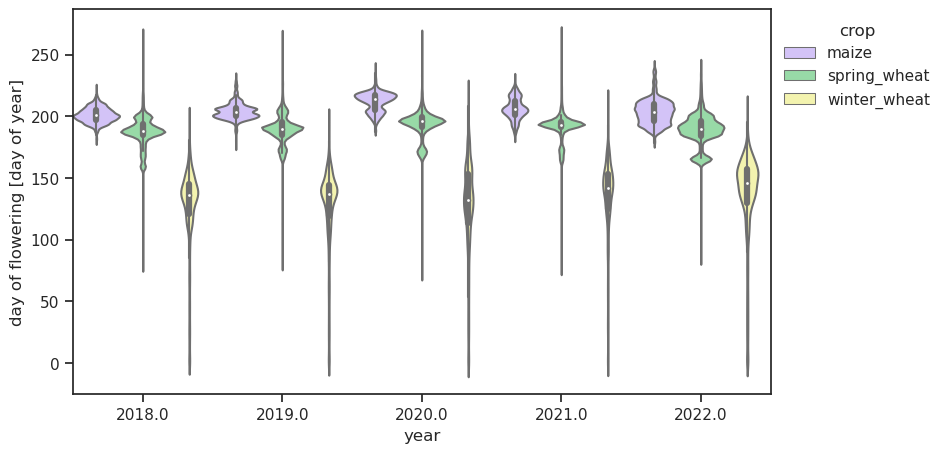

In [52]:
crop = "maize"
scenario = 2017


fig, ax = plt.subplots( figsize=(9,5))

flowering_m_ds = xr.load_dataset(f"{home.hspath}/HI_final/ggcmi_planting/scenic_EU025_f{scenario}_flowering_maize_rf.nc")
flowering_m_df = flowering_m_ds.to_dataframe().reset_index("year")
flowering_m_df["crop"] = "maize"
flowering_sw_ds = xr.load_dataset(f"{home.hspath}/HI_final/ggcmi_planting/scenic_EU025_f{scenario}_flowering_spring_wheat_rf.nc")
flowering_sw_df = flowering_sw_ds.to_dataframe().reset_index("year")
flowering_sw_df["crop"] = "spring_wheat"
flowering_ww_ds = xr.load_dataset(f"{home.hspath}/HI_final/ggcmi_planting/scenic_EU025_f{scenario}_flowering_winter_wheat_rf.nc")
flowering_ww_df = flowering_ww_ds.to_dataframe().reset_index("year")
flowering_ww_df["crop"] = "winter_wheat"

flowering_df = pd.concat([flowering_m_df,flowering_sw_df,flowering_ww_df])
flowering_f = flowering_df.where(flowering_df.year > 2017)

p = sns.violinplot(ax=ax,data=flowering_f,x="year",y="doy",hue="crop",palette=["m", "g","y"],width=1)
sns.set_theme(style="ticks", palette="pastel")
sns.move_legend(p, "upper left", bbox_to_anchor=(1, 1),frameon=False)
plt.ylabel('day of flowering [day of year]')

plt.savefig(f"{home.hsplot}/flowering/flowering_f{scenario}_bp.png",dpi=300,bbox_inches="tight")
plt.savefig(f"{home.hsplot}/paper/A5_flowering_f{scenario}_bp.png",dpi=300,bbox_inches="tight")
plt.savefig(f"{home.hsplot}/paper/A5.eps",dpi=300,bbox_inches="tight")

/tmp/ipykernel_3170831/3966255541.py:23: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


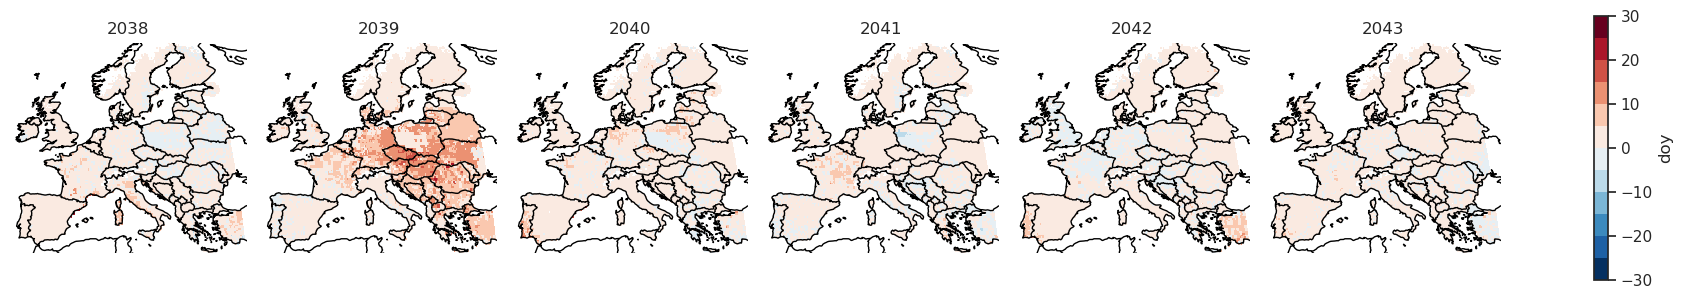

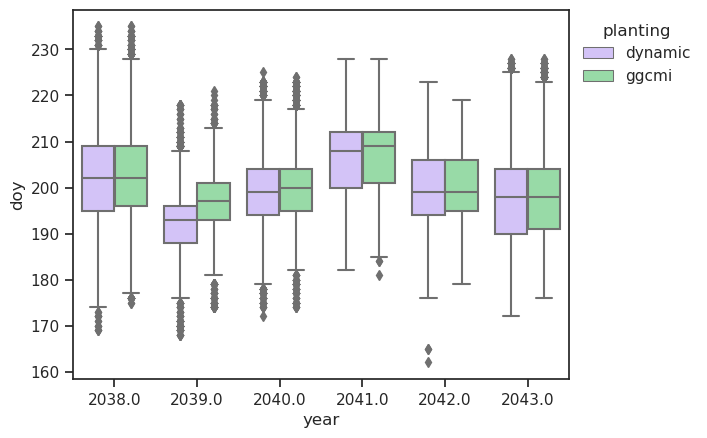

/tmp/ipykernel_3170831/3966255541.py:23: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


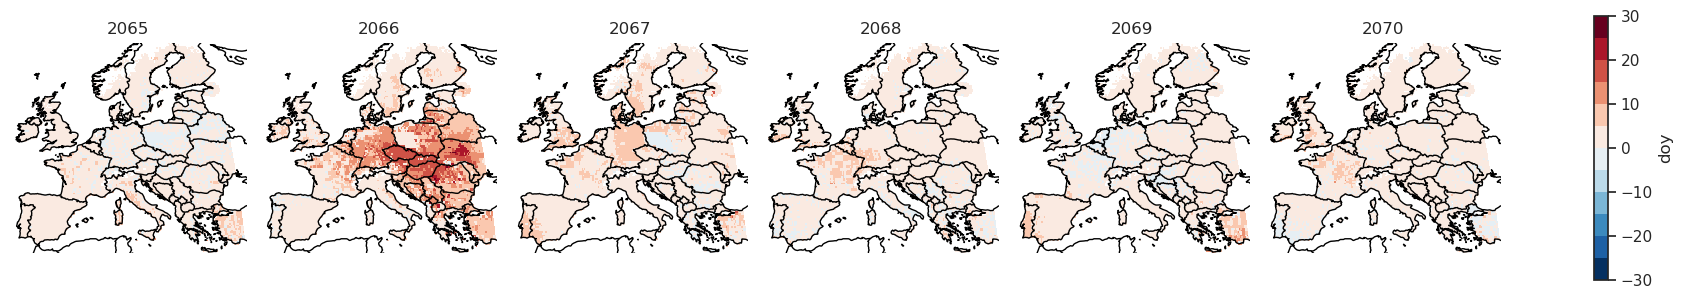

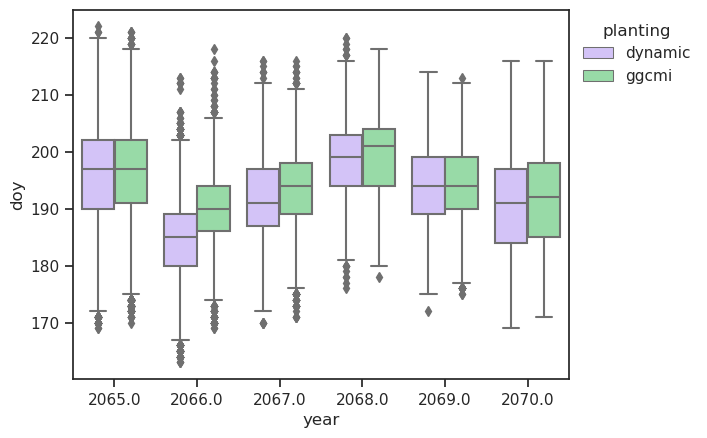

/tmp/ipykernel_3170831/3966255541.py:23: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


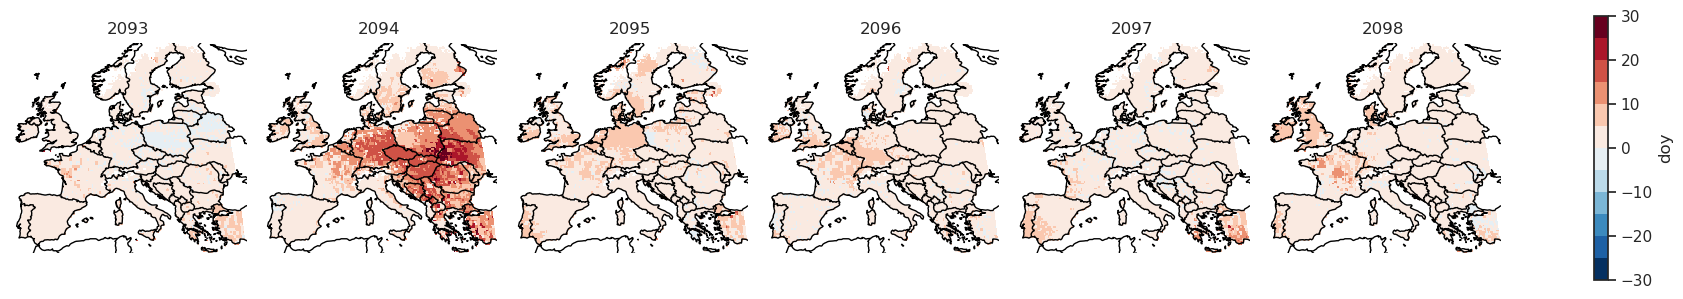

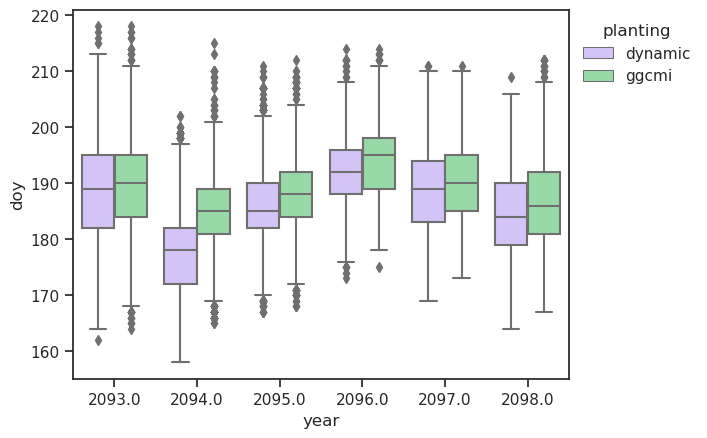

In [19]:
crop = "maize"

flowering_scens = []
for scenario in [2038,2065,2093]:
    planting="dynamic"
    flowering_dyn_ds = xr.load_dataset(f"{home.hspath}/HI_final/dynamic_planting/scenic_EU025_f{scenario}_flowering_{crop}_rf.nc")#
    flowering_ggcmi_ds = xr.load_dataset(f"{home.hspath}/HI_final/ggcmi_planting/scenic_EU025_f{scenario}_flowering_{crop}_rf.nc")

    flowering_dyn_df = flowering_dyn_ds.to_dataframe().reset_index("year")
    flowering_dyn_df["planting"] = "dynamic"
    flowering_ggcmi_df = flowering_ggcmi_ds.to_dataframe().reset_index("year")
    flowering_ggcmi_df["planting"] = "ggcmi"

    flowering_df = pd.concat([flowering_dyn_df,flowering_ggcmi_df])
    #flowering_df_2 = pd.merge(flowering_dyn_df,flowering_ggcmi_df)
    flowering_df["scenario"] = scenario
    flowering_scens.append(flowering_df)
    p = (flowering_ggcmi_ds.doy - flowering_dyn_ds.doy).plot(cmap="RdBu_r",col="year",transform=ccrs.PlateCarree(),subplot_kws={"projection": ccrs.Robinson()},levels = np.linspace(-30,30,13),extend = 'neither')
    for ax,year in zip(p.axs.flat,flowering_dyn_ds.year.values):
        ax.set_title(str(int(year)))
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS)
        ax.outline_patch.set_visible(False) 
    
    plt.savefig(f"{home.hsplot}/flowering/flowering_ggcmi_vs_planting_f{scenario}_map.png",dpi=300,bbox_inches="tight")
    plt.show()
    p = sns.boxplot(flowering_df,x="year",y="doy",hue="planting",palette=["m", "g"])
    sns.set_theme(style="ticks", palette="pastel")
    sns.move_legend(p, "upper left", bbox_to_anchor=(1, 1),frameon=False)
    
    plt.savefig(f"{home.hsplot}/flowering/flowering_ggcmi_vs_planting_f{scenario}_bp.png",dpi=300,bbox_inches="tight")
    plt.savefig(f"{home.hsplot}/paper/flowering_ggcmi_vs_planting_f{scenario}_bp.png",dpi=300,bbox_inches="tight")
    plt.savefig(f"{home.hsplot}/paper/A5_f{scenario}.eps",dpi=300,bbox_inches="tight")
    plt.show()
    

In [43]:
flowering_baseline = xr.load_dataset(f"{home.hspath}/HI_final/scenic_EU025_f2017_flowering_maize_rf.nc")

In [44]:
flowering_baseline_df = flowering_baseline.to_dataframe().groupby("date").mean()
flowering_baseline_df["doy"] = flowering_baseline_df.flowering_date.dt.dayofyear
flowering_baseline_df

flowering                flowering_date    doy
date                                                 
2017         NaN                           NaT    NaN
2018  889.629907 2017-07-22 03:34:36.658893312  203.0
2019  898.809024 2018-07-23 15:53:01.356091136  204.0
2020  894.533010 2019-07-23 09:12:07.280080896  204.0
2021  830.785494 2020-07-25 15:28:28.287292672  207.0
2022  835.664662 2021-07-22 19:37:09.985272576  203.0

In [53]:
pd.concat(flowering_scens).groupby(["scenario","planting"]).mean()

year         doy                          date
scenario planting                                                  
2038     dynamic   2040.5  199.487965 2041-01-16 11:46:46.801553920
         ggcmi     2040.5  200.506037 2041-01-17 12:08:41.602396160
2065     dynamic   2067.5  192.295333 2068-01-10 03:05:16.735305216
         ggcmi     2067.5  194.067671 2068-01-11 21:37:26.798951424
2093     dynamic   2095.5  186.055145 2096-01-03 21:19:24.507675136
         ggcmi     2095.5  188.584098 2096-01-06 10:01:06.042680832

In [52]:
pd.concat(flowering_scens).groupby(["scenario","planting","year"]).mean()

doy                          date
scenario planting year                                            
2038     dynamic  2038.0  201.453014 2038-07-20 10:52:20.396855040
                  2039.0  192.653126 2039-07-11 15:40:30.101085952
                  2040.0  199.265843 2040-07-17 06:22:48.828980480
                  2041.0  206.403126 2041-07-25 09:40:30.101085696
                  2042.0  199.651816 2042-07-18 15:38:36.885061632
                  2043.0  197.500842 2043-07-16 12:01:12.781729792
         ggcmi    2038.0  201.817016 2038-07-20 19:36:30.190939904
                  2039.0  196.719113 2039-07-15 17:15:31.336578048
                  2040.0  200.144515 2040-07-18 03:28:06.110071040
                  2041.0  206.671471 2041-07-25 16:06:55.125421056
                  2042.0  199.918289 2042-07-18 22:02:20.172219904
                  2043.0  197.765818 2043-07-16 18:22:46.679146496
2065     dynamic  2065.0  194.962186 2065-07-13 23:05:32.909022720
                  2066.0  184.475477 2066-07-03 11:24:41.242980352
                  2067.0  191.653594 2067-07-10 15:41:10.535379968
                  2068.0  198.545395 2068-07-16 13:05:22.126544384
                  2069.0  193.532198 2069-07-12 12:46:21.879446016
                  2070.0  190.603145 2070-07-09 14:28:31.718457344
         ggcmi    2065.0  195.538188 2065-07-14 12:54:59.438412288
                  2066.0  190.304568 2066-07-09 07:18:34.638712320
                  2067.0  193.567765 2067-07-12 13:37:34.885810688
                  2068.0  199.435979 2068-07-17 10:27:48.588543488
                  2069.0  194.083115 2069-07-13 01:59:41.130662400
                  2070.0  191.476413 2070-07-10 11:26:02.111568896
2093     dynamic  2093.0  188.006645 2093-07-07 00:09:34.166979072
                  2094.0  177.515350 2094-06-26 12:22:06.244852224
                  2095.0  185.646668 2095-07-04 15:31:12.107825152
                  2096.0  192.184107 2096-07-10 04:25:06.851366400
                  2097.0  188.691969 2097-07-07 16:36:26.147510272
                  2098.0  184.286129 2098-07-03 06:52:01.527517184
         ggcmi    2093.0  188.842007 2093-07-07 20:12:29.382254080
                  2094.0  184.879165 2094-07-03 21:05:59.865218560
                  2095.0  188.162673 2095-07-07 03:54:14.960688640
                  2096.0  193.811026 2096-07-11 19:27:52.631972864
                  2097.0  189.713590 2097-07-08 17:07:34.211905536
                  2098.0  186.096125 2098-07-05 02:18:25.204043776

In [9]:
flowering_df.groupby(["year","planting"]).mean()

doy                          date
year   planting                                          
2093.0 dynamic   188.006645 2093-07-07 00:09:34.166979072
       ggcmi     188.842007 2093-07-07 20:12:29.382254080
2094.0 dynamic   177.515350 2094-06-26 12:22:06.244852224
       ggcmi     184.879165 2094-07-03 21:05:59.865218560
2095.0 dynamic   185.646668 2095-07-04 15:31:12.107825152
       ggcmi     188.162673 2095-07-07 03:54:14.960688640
2096.0 dynamic   192.184107 2096-07-10 04:25:06.851366400
       ggcmi     193.811026 2096-07-11 19:27:52.631972864
2097.0 dynamic   188.691969 2097-07-07 16:36:26.147510272
       ggcmi     189.713590 2097-07-08 17:07:34.211905536
2098.0 dynamic   184.286129 2098-07-03 06:52:01.527517184
       ggcmi     186.096125 2098-07-05 02:18:25.204043776

In [78]:
sns.scatterplot(flowering_df[["doy","planting"]].reset_index(drop=True).pivot(columns='planting', values='doy'),x="dynamic",y="ggcmi")

ValueError: Index contains duplicate entries, cannot reshape

In [111]:
flowering_df_long = flowering_df[["doy","planting","year"]].reset_index(drop=True).dropna().pivot(columns='planting', values='doy')

In [112]:
flowering_df_long

planting  dynamic  ggcmi
141         185.0    NaN
142         188.0    NaN
143         188.0    NaN
305         180.0    NaN
306         181.0    NaN
...           ...    ...
262044        NaN  185.0
262046        NaN  185.0
262047        NaN  185.0
262048        NaN  185.0
262049        NaN  185.0

[128208 rows x 2 columns]

ValueError: need at least one array to concatenate

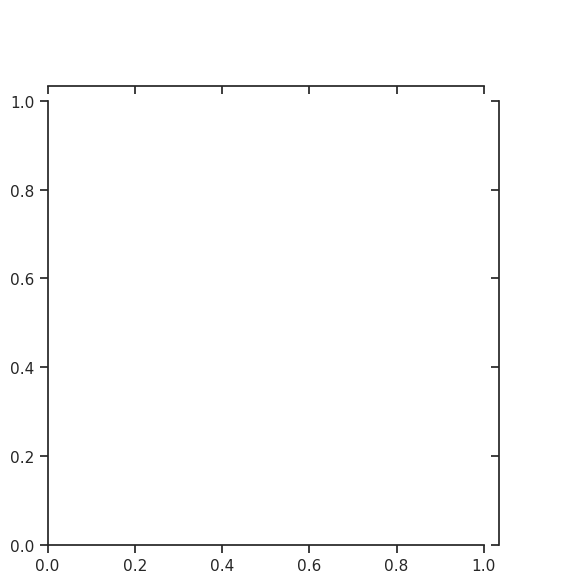

In [105]:
sns.jointplot(x="ggcmi",y="dynamic",data=flowering_df_long,kind="reg")

In [12]:
# extract for single cell
ds_cell = ds_f.sel(lon=[11],lat=[52],method="nearest").set_coords("year")
ds_cell = ds_cell.where(ds_cell.year==2094,drop = True)

In [13]:
ds_cell.where(ds_cell.aGDD_ggcmi >= ds_cell.flowering,drop=True).date[0].date.values.astype('datetime64[D]')

numpy.datetime64('2094-07-03')

In [14]:
ds_cell.where(ds_cell.aGDD_dyn >= ds_cell.flowering,drop=True).date[0].date.values.astype('datetime64[D]')

numpy.datetime64('2094-06-19')

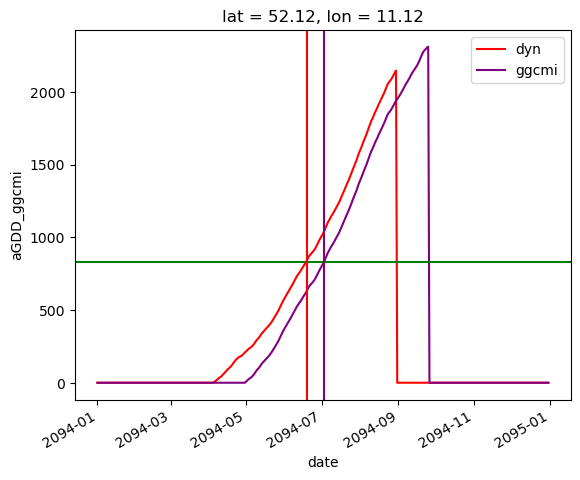

In [18]:
#plot difference between ggcmi and dynamic planting for one cell 
ds_cell.aGDD_dyn.plot(x="date",label="dyn",color="r")
ds_cell.aGDD_ggcmi.plot(x="date",label="ggcmi",color="purple")
plt.axhline(ds_cell.flowering[0,0,0],color='g')
plt.axvline(ds_cell.where(ds_cell.aGDD_dyn >= ds_cell.flowering,drop=True).date[0].date.values.astype('datetime64[D]'),color="r")
plt.axvline(ds_cell.where(ds_cell.aGDD_ggcmi >= ds_cell.flowering,drop=True).date[0].date.values.astype('datetime64[D]'),color="purple")
plt.legend()
plt.savefig(f"{home.hsplot}/flowering/dynamic_vs_ggcmi_cell52,11.png",dpi=300)

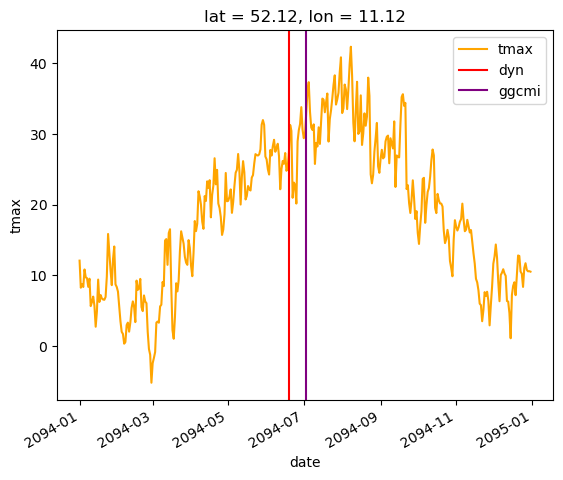

In [19]:
ds_cell.tmax.plot(x="date",label="tmax",color="orange")
plt.axvline(ds_cell.where(ds_cell.aGDD_dyn >= ds_cell.flowering,drop=True).date[0].date.values.astype('datetime64[D]'),color="r",label="dyn")
plt.axvline(ds_cell.where(ds_cell.aGDD_ggcmi >= ds_cell.flowering,drop=True).date[0].date.values.astype('datetime64[D]'),color="purple",label="ggcmi")
plt.legend()
plt.savefig(f"{home.hsplot}/flowering/dynamic_vs_ggcmi_cell52,11_temp.png",dpi=300)